In [1]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from pandas_profiling import ProfileReport

In [2]:
df_1 = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv', low_memory=False
)
df_2 = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv', low_memory=False
)
pd.options.display.max_columns = None

df_mergeado = df_2.merge(df_1, left_on = 'id', right_on = 'id')
df_mergeado.sort_values(by=['id'], inplace=True, ascending=True)
df_mergeado.sample(10)

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
86154,San Cristóbal,2009-02-28,Nornoreste,Nornoreste,NaN,59.0,55.0,90329,no,NaN,0.0,NaN,NaN,1008.9,1012.3,Nornoreste,33.0,31.7,18.9,29.7,25.9,26.0,9.0,no
35124,Constitución,2014-01-24,Noreste,Nornoreste,1.5,61.0,69.0,32271,no,7.4,0.0,8.0,8.0,1008.0,1014.0,Nornoreste,52.0,26.3,19.7,26.0,23.9,28.0,20.0,si
102135,La Boca,2015-07-03,Sursuroeste,Oestenoroeste,NaN,53.0,58.0,41823,no,NaN,0.0,1.0,7.0,1024.3,1026.1,Sursuroeste,37.0,15.9,4.7,15.3,8.5,20.0,15.0,no
82746,Villa Pueyrredón,2016-07-18,suroeste,NaN,NaN,65.0,97.0,129495,si,NaN,9.6,NaN,NaN,1020.3,1019.4,Sursuroeste,28.0,14.9,6.5,13.5,10.0,9.0,0.0,no
43537,Caballito,2010-08-01,Noroeste,Noroeste,NaN,50.0,64.0,18692,no,NaN,0.0,NaN,NaN,1014.7,1021.2,Noroeste,48.0,19.5,9.6,18.4,14.5,24.0,17.0,no
80969,San Nicolás,2016-03-09,Este,Sureste,4.5,82.0,77.0,95846,si,6.6,25.0,7.0,7.0,1010.9,1014.2,Estesureste,46.0,30.2,25.7,29.0,28.2,30.0,13.0,si
106323,Villa Devoto,2011-08-17,Oestenoroeste,Noroeste,NaN,56.0,91.0,112539,si,NaN,5.2,NaN,NaN,1023.5,1024.3,Oeste,37.0,17.5,8.0,15.6,12.8,20.0,6.0,no
114295,Parque Chacabuco,2012-10-23,Nornoreste,Nornoreste,11.9,4.0,18.0,71754,no,8.0,0.0,5.0,6.0,1018.7,1023.0,Noreste,52.0,28.3,8.9,26.2,17.4,28.0,37.0,no
38229,Puerto Madero,2016-08-26,Oestesuroeste,suroeste,3.2,55.0,100.0,80694,si,2.4,1.4,7.0,7.0,1020.6,1022.3,Oeste,28.0,12.7,5.0,12.4,7.5,11.0,6.0,no
82813,Puerto Madero,2011-05-14,Sursuroeste,Oeste,5.4,73.0,99.0,78822,si,0.8,9.6,7.0,7.0,1024.3,1022.5,Sursuroeste,43.0,13.2,6.4,11.5,8.1,24.0,9.0,si


# Feature engineering
### Buscamos filas duplicadas
### Consideramos a una fila duplicada unicamente cuando se repite el dia y el barrio

In [3]:
display(df_mergeado[df_mergeado.duplicated(subset=['barrio','dia'],keep=False)])

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente


## Variables __categoricas__
1. Barrio 
2. direccion_viento_tarde
3. direccion_viento_temprano
4. rafaga_viento_max_direccion

### Comenzamos por reemplazar los valores nulos en direcciones de viento y ráfagas por una nueva opcion que puede tomar la feature : "Otra direccion"

In [4]:
df_mergeado['direccion_viento_tarde'].replace(np.nan, 'Otra direccion', inplace=True)
df_mergeado['direccion_viento_temprano'].replace(np.nan, 'Otra direccion', inplace=True)
df_mergeado['rafaga_viento_max_direccion'].replace(np.nan, 'Otra direccion',inplace=True)

### Ademas reemplazamos el valor del barrio palermo que vino como 'Palermo cheto' a palermo, ya que seria poco profesional operar con el dato escrito de esta manera

In [5]:
df_mergeado['barrio'].replace('Palermo cheto', 'Palermo', inplace=True)

### Luego verificamos que ninguna feature categorica tenga valores repetidos o sin sentido por errores de tipado 

In [6]:
df_mergeado.barrio.value_counts().to_frame()

,barrio
Palermo,3713
Liniers,2737
Constitución,2657
Villa Soldati,2611
Retiro,2580
Villa Luro,2578
Villa Real,2561
Parque Avellaneda,2526
San Telmo,2518
San Nicolás,2482


In [7]:
df_mergeado.direccion_viento_temprano.value_counts().to_frame()

,direccion_viento_temprano
Nornoreste,12784
Norte,9453
Otra direccion,8403
Sureste,7437
Este,7391
Sursureste,7244
Noroeste,7003
Sur,6948
suroeste,6785
Oeste,6742


In [8]:
df_mergeado.direccion_viento_tarde.value_counts().to_frame()

,direccion_viento_tarde
Nornoreste,11546
Sureste,8657
Oeste,8053
Sur,7930
Oestesuroeste,7627
Sursureste,7480
suroeste,7477
Norte,7180
Oestenoroeste,7096
Noroeste,6893


In [9]:
df_mergeado.llovieron_hamburguesas_hoy.value_counts().to_frame()

,llovieron_hamburguesas_hoy
no,88359
si,25394


In [10]:
df_mergeado.rafaga_viento_max_direccion.value_counts().to_frame()

,rafaga_viento_max_direccion
Nornoreste,10512
Otra direccion,8269
Oeste,7952
Sureste,7502
Norte,7432
Este,7428
Sursureste,7365
Sur,7314
Oestesuroeste,7227
suroeste,7161


#### Vemos que todos los valores son unicos, no hay necesidad de alterar las features y podemos seguir con la conversion a valores numericos

## ...












## ....









## Variables __numéricas__
1.

### Comenzamos por buscar cuáles columnas tienen missings

In [11]:
df_mergeado.fillna(np.nan, inplace = True)
df_nulos = df_mergeado.isnull().sum().to_frame(name="NaN_Count")
df_nulos['NaN_%'] = df_nulos['NaN_Count'] / df_mergeado.count()
df_nulos.sort_values(by=['NaN_%']) #este % por alguna razón muestra mal a partir de nubosidad_temprano

,NaN_Count,NaN_%
barrio,0,0.000000
dia,0,0.000000
direccion_viento_tarde,0,0.000000
direccion_viento_temprano,0,0.000000
id,0,0.000000
rafaga_viento_max_direccion,0,0.000000
temp_max,1003,0.008694
temp_min,1187,0.010306
temperatura_temprano,1410,0.012265
velocidad_viendo_temprano,1413,0.012292


Vemos que algunos de los features tienen menos de un 1.5% de NaNs, por lo cual usar la media para rellenarlos no implicaría una disonancia significativa en la información, sinó más bien un suavizado de esos casos vacíos.

In [12]:
df_2 = df_mergeado.copy()
df_2['temp_max'].replace(np.nan, df_2['temp_max'].mean(), inplace = True)
df_2['temp_min'].replace(np.nan, df_2['temp_min'].mean(), inplace = True)
df_2['temperatura_temprano'].replace(np.nan, df_2['temperatura_temprano'].mean(), inplace = True)
df_2['velocidad_viendo_temprano'].replace(np.nan, df_2['velocidad_viendo_temprano'].mean(), inplace = True)

df_nulos = df_2.isnull().sum().to_frame(name="NaN_Count")
df_nulos['NaN_%'] = df_nulos['NaN_Count'] / df_2.count()
df_nulos.sort_values(by=['NaN_%']) #este % por alguna razón muestra mal a partir de nubosidad_temprano

,NaN_Count,NaN_%
barrio,0,0.000000
dia,0,0.000000
direccion_viento_tarde,0,0.000000
direccion_viento_temprano,0,0.000000
temperatura_temprano,0,0.000000
id,0,0.000000
temp_min,0,0.000000
velocidad_viendo_temprano,0,0.000000
temp_max,0,0.000000
rafaga_viento_max_direccion,0,0.000000


# Formulación de Preguntas y Visualización
## Primero nos hacemos una serie de preguntas para comprender y analizar mejor nuestros datos:  

1. ¿Suponiendo desconocimiento de todas las features excepto el target, que tan probable es que lluevan hamburguesas al dia siguiente?
 2. ¿De qué manera se relaciona el barrio con que lluevan hamburguesas al dia siguiente?
 3. ¿De qué manera se relaciona el barrio con que lluevan hamburguesas al dia siguiente, en ese mismo barrio? (esta no me convence)
 4. ¿Si llovieron hamburguesas hoy, qué tan probable es que lluevan hamburguesas mañana?
 5. ¿Features con gran numero de missings como horas_de_sol, mm_evaporados_agua, y las nubosidades para la mañana y la tarde, tienen correlación con el target?
 6. ¿Cómo afecta la feature mm_lluvia_dia al target?
 7. ¿Si hubo una correlación en (6.), qué features afectan a mm_lluvia_dia?
 
Buscamos entender cada uno de los datos, cómo se relacionan entre sí y ver que conclusiones podemos obtener. A partir de ellos vamos a determinar los factores que determinan si lloverá al dia siguiente, y verificaremos cuáles features son reelevantes de mantener en el dataset.

### 1.¿Suponiendo desconocimiento de todas las features excepto el target, que tan probable es que lluevan hamburguesas al dia siguiente?

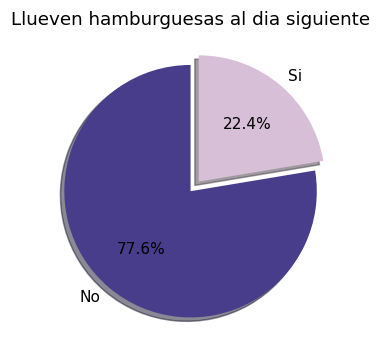

In [13]:
plt.figure(figsize=(5.4, 3.8), dpi=110)
labels = ['No', 'Si']
sizes = df_2['llovieron_hamburguesas_al_dia_siguiente'].value_counts()
explode = (0, 0.1)
plt.title('Llueven hamburguesas al dia siguiente')
plt.pie(sizes, explode=explode, data = df_2['llovieron_hamburguesas_al_dia_siguiente'],labels = labels ,autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['darkslateblue', 'thistle'])
plt.show()

Podemos corroborar, que desconociendo el resto de features, para el 77.6% de los registros en el dataset al dia siguiente no llueven hamburguesas. Esto quiere decir que si armaramos una baseline que simplemente devuelva siempre "NO", el accuracy ya sería de ese porcentaje. Sin embargo, no solo es un accuracy que no nos satisface, sinó que resulta en algo poco reutilizable que desperdicia el resto de información.

### 2. ¿De qué manera se relaciona el barrio con que lluevan hamburguesas al dia siguiente?

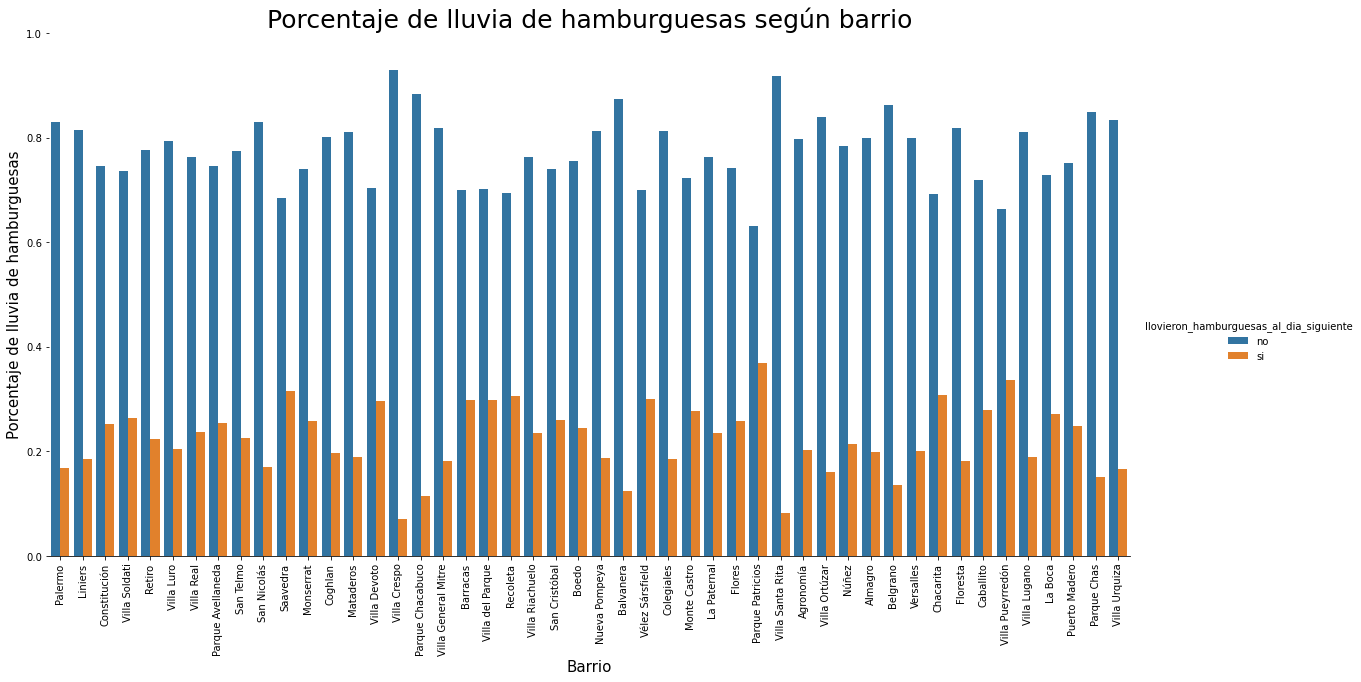

In [14]:
lluvurguesas_por_barrio = df_2.groupby(by="barrio")['llovieron_hamburguesas_al_dia_siguiente'].value_counts(normalize=True)

lluvurguesas_por_barrio = lluvurguesas_por_barrio.to_frame()
lluvurguesas_por_barrio.rename(columns={'llovieron_hamburguesas_al_dia_siguiente':'porcentaje_por_barrio'},inplace=True)
lluvurguesas_por_barrio.reset_index(inplace=True)

g = sns.catplot(
    data=lluvurguesas_por_barrio, kind="bar",
    x="barrio", y="porcentaje_por_barrio", hue="llovieron_hamburguesas_al_dia_siguiente", order=df_2["barrio"].value_counts().index,
    ci=None, height=8,aspect=2
)
plt.title("Porcentaje de lluvia de hamburguesas según barrio",  fontsize=25)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("Barrio", "Porcentaje de lluvia de hamburguesas",  fontsize=15)

Podemos ver que en ningún barrio es predominante el "SI" para la feature llovieron_hamburguesas_al_dia_siguiente, por lo que no podemos hacer ninguna afirmación positiva para la lluvia de hamburguesas según el barrio. Sin embargo, podemos notar que ciertos barrios como Parque Patricios y Villa Pueryrredón, tienen lluvia de hamburguesas al dia siguiente más seguido de lo normal (un \~30% de las veces), mientras que barrios como Villa Crespo y Villa Santa Rita rondan números bajos (\~10%).

### 4.¿Si llovieron hamburguesas hoy, qué tan probable es que lluevan hamburguesas mañana?

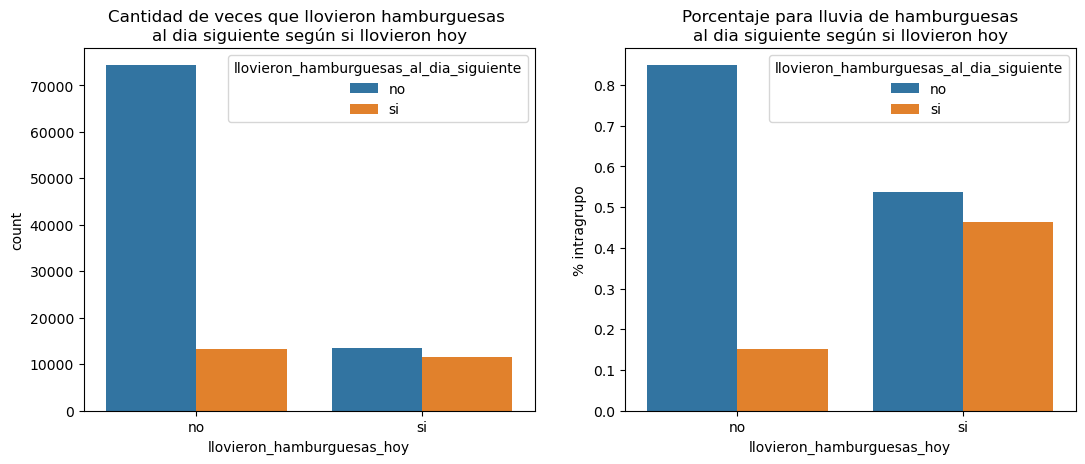

In [24]:
#plt.figure(dpi=100, figsize=(10, 5))
#sns.countplot(data=df_2, x='llovieron_hamburguesas_hoy', hue='llovieron_hamburguesas_al_dia_siguiente')
#plt.title("Cantidad de veces que llovieron hamburguesas al dia siguiente según si llovieron hoy")
#plt.ylabel("Cantidad")
#plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

sns.countplot(data=df_2, x='llovieron_hamburguesas_hoy', hue='llovieron_hamburguesas_al_dia_siguiente', ax=axes[0])
axes[0].set_title("Cantidad de veces que llovieron hamburguesas \n" +  "al dia siguiente según si llovieron hoy")

sns.barplot(
    data=df_2.groupby("llovieron_hamburguesas_hoy")
    .llovieron_hamburguesas_al_dia_siguiente.value_counts(normalize=True)
    .rename("llovieron_al_dia_siguiente_prop")
    .reset_index(),
    x='llovieron_hamburguesas_hoy',
    y="llovieron_al_dia_siguiente_prop",
    hue='llovieron_hamburguesas_al_dia_siguiente',
    ax=axes[1],
)
axes[1].set_ylabel("% intragrupo")
axes[1].set_title("Porcentaje para lluvia de hamburguesas\n" +  "al dia siguiente según si llovieron hoy")

plt.show()

Podemos ver que si bien la cantidad de veces que llueven_hamburguesas_al_dia siguiente es prácticamente la misma en ambas mitades del gráfico, su proporción con llovieron_hamburguesas_hoy cambia radicalmente. Concluimos de esta visualización, que si llovieron hamburguesas hoy, hay practicamente un 50% de probabilidades que llueva mañana, mientras que si hoy no llovieron hamburguesas, entonces esa probabilidad es mucho menor, de aproximadamente el 15%

### 6.¿Cómo afecta la feature mm_lluvia_dia al target?

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


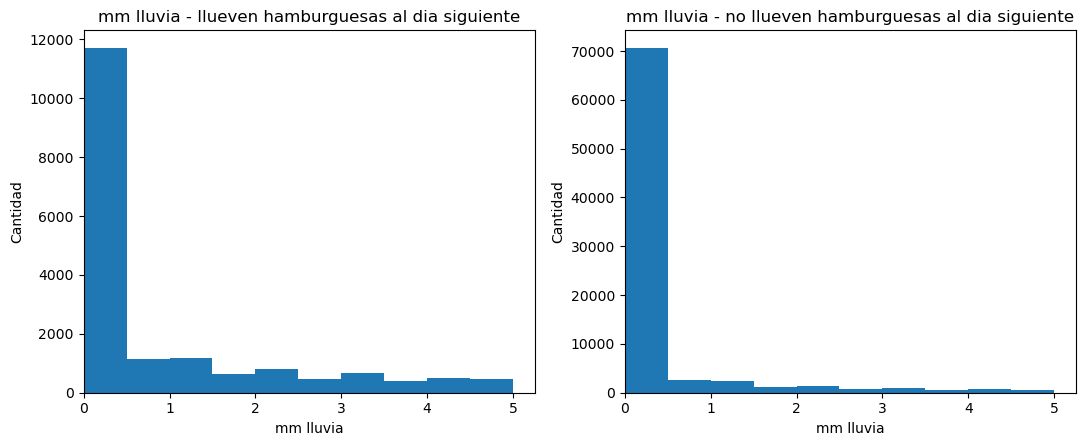

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df_2[df_2.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df_2[df_2.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.mm_lluvia_dia.plot(kind='hist', range=[0, 5], ax=axes[0], xlim=0)
axes[0].set_title("mm lluvia - llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("mm lluvia")

df_no_llovio_h_maniana.mm_lluvia_dia.plot(kind='hist', range=[0,5], ax=axes[1], xlim=0)
axes[1].set_title("mm lluvia - no llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("mm lluvia")
plt.show()

Se puede observar que si tomamos en cuenta las distintas escalas del eje de las ordenadas (cantidad de dias donde llovieron o no hamburguesas), entonces la distribución de los mm de lluvia es muy similar en ambas, por lo que no nos llevaria a ninguna estimación concluyente del target.

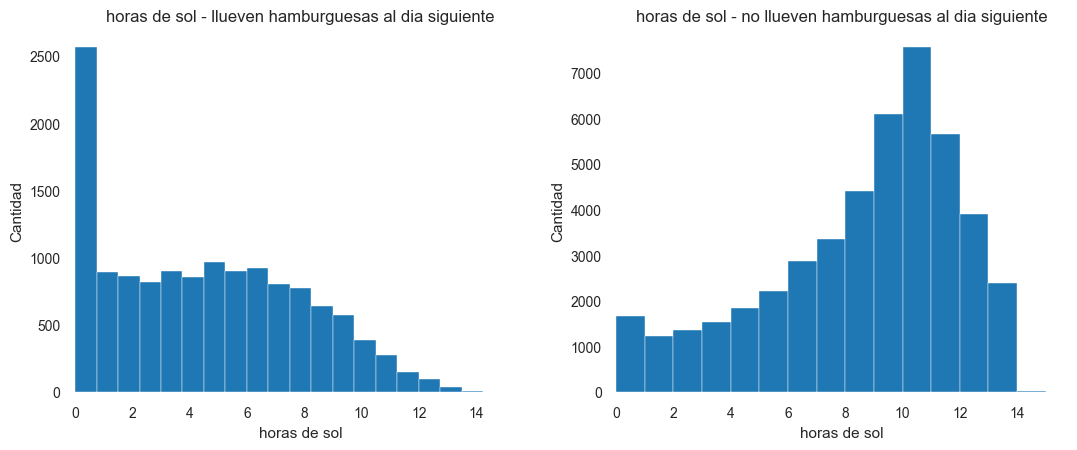

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df_2[df_2.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df_2[df_2.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.horas_de_sol.plot(kind='hist', bins=20, range=[0, 15], ax=axes[0], xlim=0)
axes[0].set_title("horas de sol - llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("horas de sol")

df_no_llovio_h_maniana.horas_de_sol.plot(kind='hist', bins=15, range=[0,15], ax=axes[1], xlim=0)
axes[1].set_title("horas de sol - no llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("horas de sol")
plt.show()